# Import Packages

In [1]:
import numpy as np                                # For matrix operations and numerical processing
import pandas as pd                               # For munging tabular data
import matplotlib.pyplot as plt                   # For charts and visualizations
from IPython.display import Image                 # For displaying images in the notebook
from IPython.display import display               # For displaying outputs in the notebook
from time import gmtime, strftime                 # For labeling SageMaker models, endpoints, etc.
import sys                                        # For writing outputs to notebook
import math                                       # For ceiling function
import json                                       # For parsing hosting outputs
import os                                         # For manipulating filepath names
import zipfile                                    # unzips the dataset
from sagemaker import image_uris
from sagemaker.inputs import TrainingInput
from sagemaker.estimator import Estimator
from sagemaker.serializers import CSVSerializer
import psycopg2
from sqlalchemy import create_engine
import datetime
from scipy import stats
from patsy import dmatrices
import statsmodels.api as sm
import seaborn as sns
import boto3
import re
from sagemaker import get_execution_role 
from time import gmtime, strftime
import sys 
import sagemaker

# Read data from S3

In [2]:

sess = sagemaker.Session()

bucket = 'aws-immersion-day--ml'# enter your s3 bucket where you will copy data and model artifacts
prefix = 'PROPENSITY-DATA/01-EMAIL/xgboost/training-files'
data_key = 'PROPENSITY-DATA/01-EMAIL/simulated_email_data_lab.csv'
data_location = 's3://{}/{}'.format(bucket, data_key)
role = get_execution_role()
data_s3=pd.read_csv(data_location)

In [3]:
df_welcome=data_s3.copy()

# 1. Session 1--------------------------------------------------------------------------------

# Data Preparation

### <span style="color:blue"> 1.a) Checking Data Types

In [4]:
df_welcome.dtypes

user_id                    int64
date                      object
validity_type_bad          int64
bounce_type_soft           int64
bounce_type_hard           int64
bounce_type_other          int64
paycheck_amount_gross      int64
type_of_income           float64
account_number             int64
type_of_loan             float64
autopay_check              int64
bankruptcy_check           int64
deferral_check             int64
customer_account_age       int64
collateral_check           int64
homeowner_check            int64
target_variable            int64
state                     object
type_of_address           object
branch_distance            int64
user_age                  object
credit_score               int64
plans_count                int64
retired_check              int64
freq_payment               int64
job_duration              object
dtype: object

In [5]:
(df_welcome.select_dtypes(['object'])).columns

Index(['date', 'state', 'type_of_address', 'user_age', 'job_duration'], dtype='object')

#### <span style="color:maroon"> Fix datatype of date column 

In [6]:
df_welcome.date.head(5)

0    12/24/2019
1    11/30/2019
2    11/22/2019
3    11/14/2019
4      11-04-19
Name: date, dtype: object

In [7]:
df_welcome.date=df_welcome.date.astype('datetime64[ns]')
df_welcome.date.head(5)

0   2019-12-24
1   2019-11-30
2   2019-11-22
3   2019-11-14
4   2019-11-04
Name: date, dtype: datetime64[ns]

#### <span style="color:maroon"> Fix use_age column 

In [8]:
df_welcome.user_age.head(5)

0    52 years
1    24 years
2    38 years
3    38 years
4    37 years
Name: user_age, dtype: object

##### Years will have to be removed from the column to use it for modeling

In [9]:
split_words = df_welcome["user_age"].str.split(" ", expand = True)
df_welcome["user_age"] = split_words[0]
#df_welcome["user_age"] = df_welcome["user_age"].astype('float')
df_welcome["user_age"] = df_welcome["user_age"].astype('int')
df_welcome["user_age"].head(5)

0    52
1    24
2    38
3    38
4    37
Name: user_age, dtype: int64

#### <span style="color:maroon"> Fix job_duration column 

In [10]:
df_welcome.job_duration.head(5)

0    33 years
1     3 years
2    17 years
3    15 years
4    12 years
Name: job_duration, dtype: object

In [11]:
split_words = df_welcome["job_duration"].str.split(" ", expand = True)
df_welcome["job_duration"] = split_words[0]
df_welcome["job_duration"] = df_welcome["job_duration"].astype(int)
df_welcome["job_duration"].head(5)

0    33
1     3
2    17
3    15
4    12
Name: job_duration, dtype: int64

### <span style="color:blue">1.b) Data Quality Check

#### <span style="color:maroon"> Missing value Identification 

In [12]:
df_welcome.replace("",np.nan,inplace=True) 

In [13]:
percent_missing = df_welcome.isnull().sum() * 100 / len(df_welcome)
missing_value_df = pd.DataFrame({'column_name': df_welcome.columns, 'percent_missing': percent_missing})
missing_value_df.sort_values('percent_missing', ascending=False,inplace=True)
missing_value_df.head(5)

,column_name,percent_missing
type_of_loan,type_of_loan,5.42
type_of_income,type_of_income,4.23
user_id,user_id,0.00
collateral_check,collateral_check,0.00
freq_payment,freq_payment,0.00


#### <span style="color:maroon"> Treating missing values

In [14]:
#Type of loan
df_welcome['type_of_loan']=df_welcome['type_of_loan'].fillna('not_avl')
df_welcome['type_of_loan']=df_welcome['type_of_loan'].astype('category')

In [15]:
#Type of Income
df_welcome['type_of_income']=df_welcome['type_of_income'].fillna('not_avl')
df_welcome['type_of_income']=df_welcome['type_of_income'].astype('category')

# Exploratory Data Analysis


### <span style="color:blue"> 1.c) General analysis

#### <span style="color:maroon"> What is the time period of the data?

In [16]:
df_welcome.date.describe()

count                   10000
unique                     72
top       2019-10-27 00:00:00
freq                      163
first     2019-10-21 00:00:00
last      2019-12-31 00:00:00
Name: date, dtype: object

#### <span style="color:maroon"> Average number of communications per day?

In [17]:
df_welcome.date.count()/df_welcome.date.nunique()

138.88888888888889

#### <span style="color:maroon">  What is the distribution of the target variable?

Text(0.5, 1.0, 'target_variable-barplot')

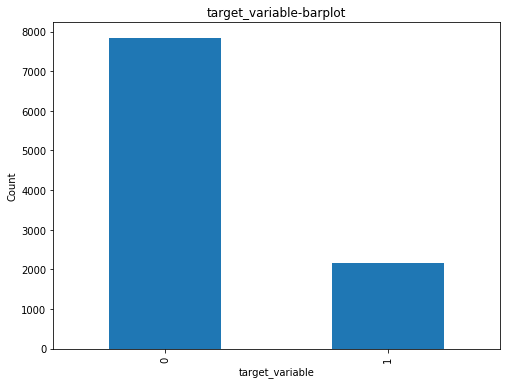

In [18]:
fig, ax = plt.subplots(figsize=(8, 6))
df_welcome['target_variable'].value_counts().plot(kind='bar', ax=ax)
ax.set_xlabel('target_variable')
ax.set_ylabel('Count')
ax.set_title('target_variable-barplot')

##### We notice that the classes are highly imbalanced

In [19]:
df_welcome['target_variable'].value_counts(normalize=True)

0    0.7841
1    0.2159
Name: target_variable, dtype: float64

##### Percentage of Positive result: 22 %
##### This implies that class imbalance treatment would need to be done going forward

### <span style="color:blue"> 1.d)  Analysis of Independent Variables(Univariate analysis)

* ### <span style="color:navy">  Quantitative variables

#### <span style="color:maroon">Variable Name : paycheck_amount_gross

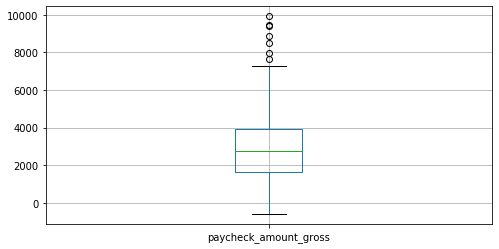

In [20]:
# paycheck_amount_gross
fig, ax = plt.subplots(figsize=(8, 4))
df_welcome.boxplot(column='paycheck_amount_gross')

##### We notice that there are outliers in this column as per the boxplot, lets confirm it with IQR

In [21]:
values=sorted(df_welcome.paycheck_amount_gross)
Q1,Q3 = np.percentile(values , [25,75])
IQR = Q3 - Q1
lower_range = Q1 - (1.5 * IQR)
upper_range = Q3 + (1.5 * IQR)

len(df_welcome[(df_welcome.paycheck_amount_gross < lower_range) | (df_welcome.paycheck_amount_gross > upper_range)])

7

##### We confirm there are 7 outliers and will remove them

#### <span style="color:maroon">  paycheck_amount_gross - Outlier treatment

In [22]:
df_welcome.drop(df_welcome[(df_welcome.paycheck_amount_gross < lower_range) | (df_welcome.paycheck_amount_gross > upper_range) ].index , inplace=True)


##### We also notice that the gross payckeck amount is less than 0 at some places. Those need to be deleted as well.

In [23]:
df_welcome.drop(df_welcome[(df_welcome.paycheck_amount_gross < 0)  ].index , inplace=True)

#### <span style="color:maroon">Variable Name : customer_account_age

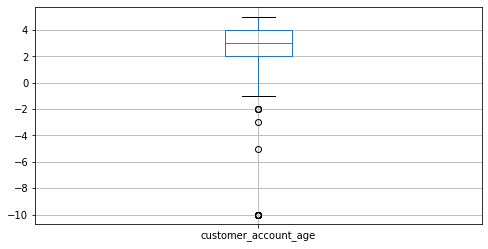

In [24]:
fig, ax = plt.subplots(figsize=(8, 4))
df_welcome.boxplot(column='customer_account_age')

##### We notice that there are values below 0. Since this is definitely erroneous, we will go ahead and remove it.

In [25]:
df_welcome.drop(df_welcome[(df_welcome.customer_account_age < 0) ].index , inplace=True)

#### <span style="color:maroon">Variable Name : Credit Score

(array([1041., 2140., 1716., 2640., 2432.]),
 array([300, 400, 500, 600, 700, 850]),
 <a list of 5 Patch objects>)

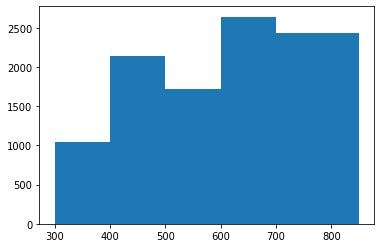

In [26]:
plt.hist(df_welcome.credit_score, bins = [300,400,500,600,700,850]) 

##### We notice that the credit scores are mostly on the higher end (600-700)

* ### <span style="color:navy">  Categorical variables

#### <span style="color:maroon">Variable Name : Banckruptcy check

Text(0.5, 1.0, 'bankruptcy_check-barplot')

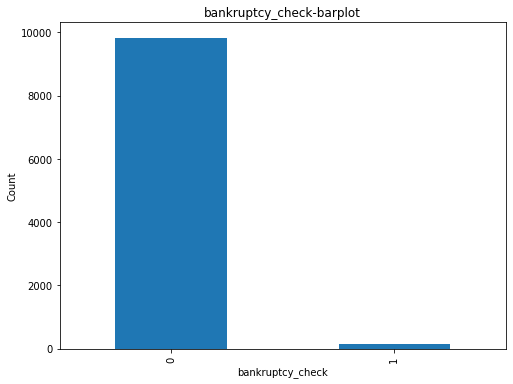

In [27]:
fig, ax = plt.subplots(figsize=(8, 6))
df_welcome['bankruptcy_check'].value_counts().plot(kind='bar', ax=ax)
ax.set_xlabel('bankruptcy_check')
ax.set_ylabel('Count')
ax.set_title('bankruptcy_check-barplot')

In [28]:
len(df_welcome[df_welcome.bankruptcy_check==1])/len(df_welcome)*100 

1.4344467850336042

##### So we notice that approximately 1.5% of the potential leads had bankrupted before

#### <span style="color:maroon">Variable Name : state

Text(0.5, 1.0, 'state')

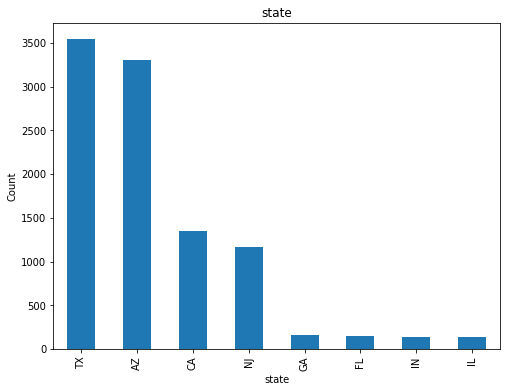

In [29]:
fig, ax = plt.subplots(figsize=(8, 6))
df_welcome['state'].value_counts().plot(kind='bar', ax=ax)
ax.set_xlabel('state')
ax.set_ylabel('Count')
ax.set_title('state')

###### We notice that Texas and Arizona have had the most number of outreaches

### <span style="color:blue"> 1.e)  Analysis of Independent Variables with respect to other varibales(Bi Variate analysis)

#### <span style="color:maroon"> Correlation Analysis 

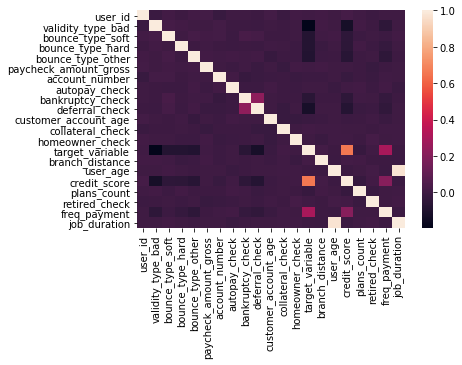

In [30]:
#df_welcome['gross_monthly_income'] = df_welcome.paycheck_amount_gross * df_welcome.freq_payment
corr=df_welcome.corr(method ='pearson')
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns)

##### Factors credit score, frequency of payment look promising. Let's look further into them with respect to the Target Variable

#### <span style="color:maroon">  Credit score vs Target Variable

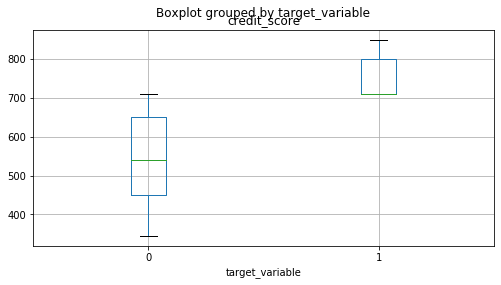

In [31]:
fig, ax = plt.subplots(figsize=(8, 4))
df_welcome.boxplot(column='credit_score', by= 'target_variable', ax=ax)

##### Again, we notice clear distinction in distribution between the 2 responses. Credit score is on an higher end for positive response

Now, let's analyse correlations between categorical variables and the target variable using cross-tabulation

#### <span style="color:maroon">  Freq_payment vs Target Variable

In [32]:
output_by_payment_freq= pd.crosstab(df_welcome['freq_payment'],df_welcome['target_variable'],normalize='columns')
output_by_payment_freq= output_by_payment_freq.sort_values(by=1, ascending=False)
output_by_payment_freq

target_variable,0,1
freq_payment,,
4,0.172185,0.569432
2,0.319187,0.430568
1,0.249137,0.000000
3,0.259491,0.000000


So we notice that people with payment frequency =4 tend to respond positively than the ones with other.

#### <span style="color:maroon"> State vs Target Variable

In [33]:
output_by_state= pd.crosstab(df_welcome['state'], df_welcome['target_variable'], normalize='columns')
output_by_state= output_by_state.sort_values(by=1, ascending=False)
output_by_state

target_variable,0,1
state,,
CA,0.019430,0.556850
NJ,0.039755,0.399814
AZ,0.416592,0.021901
TX,0.448038,0.021435
FL,0.019302,0.000000
GA,0.020580,0.000000
IL,0.017896,0.000000
IN,0.018407,0.000000


We see here that California and New Jersey have performed tremendously better than the other states.

#### <span style="color:maroon"> type_of_address vs Target Variable

In [34]:
output_by_address_type= pd.crosstab(df_welcome['type_of_address'], df_welcome['target_variable'], normalize='columns')
output_by_address_type

target_variable,0,1
type_of_address,,
M,0.494439,0.018173
P,0.505561,0.981827


##### We Notice that people providing their primary address types tend to respond positively to the solicitation campaigns.

#### <span style="color:maroon">  homeowner_check vs Target Variable

In [35]:
output_by_homeowner_check= pd.crosstab(df_welcome['target_variable'], df_welcome['homeowner_check'], normalize='columns')
output_by_homeowner_check= output_by_homeowner_check.sort_values(by=1, axis=1, ascending=False)
output_by_homeowner_check

homeowner_check,1,0
target_variable,,
0,0.782258,0.785786
1,0.217742,0.214214


##### Here we see that there the homeowner flag does not make any difference to the likelihood of a positive result. <br>Thus homeowner_check may not be a strong influencer for the model. 

# 2. Session 2 -Feature Engineering--------------------------------------------------------------

In [36]:
df_welcome=df_welcome.sort_values(by='date',ascending=False)
df_welcome=df_welcome.reset_index()
del df_welcome['index']

#### <span style="color:maroon">Create IS HOLIDAY feature

In [37]:
#Create IS HOLIDAY feature
!pip install holidays

import holidays
import datetime
import pandas as pd

us_holidays=[]
us_dates=[]

for date in holidays.UnitedStates(years=[2019]).items():
    us_dates.append(str(date[0]))
    us_holidays.append(str(date[1]))

cal=pd.DataFrame()
cal['date']=us_dates
cal['holidays']=us_holidays

cal['date']=pd.to_datetime(cal['date'], dayfirst=True)

df_welcome['is_holiday']= [ 1 if str(val).split()[0] in us_dates else 0 for val in df_welcome['date']]

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [38]:
df_welcome.is_holiday.value_counts(normalize=True)

0    0.956164
1    0.043836
Name: is_holiday, dtype: float64

#### <span style="color:maroon">Calculate date difference from Holidays

In [39]:
%%time
# Calculate date difference from Holidays
cal.date=cal.date.astype('datetime64[ns]')
cal['year']=cal.date.dt.year
cal['date']=pd.to_datetime(cal['date'], dayfirst=True).dt.date
#data_all_move_exp_df=data_all_move_exp_df.reset_index()
#del data_all_move_exp_df['index']


for i,j in df_welcome.iterrows():
    for x,y in cal.iterrows():
        holiday=str(cal.iloc[x].holidays)
        if df_welcome.iloc[i].date.year==cal.iloc[x].date.year:
            if df_welcome.iloc[i].date.date()<cal.iloc[x].date:
                df_welcome.loc[i, 'event_'+holiday] =(cal.iloc[x].date-df_welcome.iloc[i].date.date()).total_seconds()/3600
                

CPU times: user 3min, sys: 6.29 ms, total: 3min
Wall time: 3min


In [40]:
df_welcome.tail()

,user_id,date,validity_type_bad,bounce_type_soft,bounce_type_hard,bounce_type_other,paycheck_amount_gross,type_of_income,account_number,type_of_loan,...,user_age,credit_score,plans_count,retired_check,freq_payment,job_duration,is_holiday,event_Christmas Day,event_Thanksgiving,event_Veterans Day
9964,41112,2019-10-21,0,1,0,0,2417,32,4700305,20,...,36,490,7,0,4,16,0,1560.0,912.0,504.0
9965,25608,2019-10-21,0,0,0,0,4586,21,6998511,11,...,29,485,4,0,3,10,0,1560.0,912.0,504.0
9966,97692,2019-10-21,0,0,0,0,4474,32,1117746,20,...,49,484,3,0,2,29,0,1560.0,912.0,504.0
9967,690,2019-10-21,0,0,0,0,4798,16,7472402,13,...,35,800,4,0,4,10,0,1560.0,912.0,504.0
9968,70142,2019-10-21,0,0,0,0,830,13,1419537,24,...,25,710,5,0,4,3,0,1560.0,912.0,504.0


#### <span style="color:maroon">Create day_of_week column

In [41]:
## split datetime to date and hour from time
df_welcome.date=df_welcome.date.astype('datetime64[ns]')
df_welcome['day_of_week'] = df_welcome['date'].dt.dayofweek
df_welcome['day_of_week'].unique()

array([1, 0, 6, 5, 4, 3, 2])

#### <span style="color:maroon"> Create end_month column

In [42]:
#create end of month
df_welcome['end_month'] = df_welcome['date'].apply(lambda x: 1 if ((x.day)-(x.days_in_month)==0) else 0)

#### <span style="color:maroon">Calculate Gross Monthly income 

In [43]:
#calculate gross monthly income
df_welcome.freq_payment= df_welcome.freq_payment.astype('int')         
df_welcome['gross_monthly_income'] = df_welcome.paycheck_amount_gross *df_welcome.freq_payment

#### <span style="color:maroon"> Gross monthly income vs Target Variable

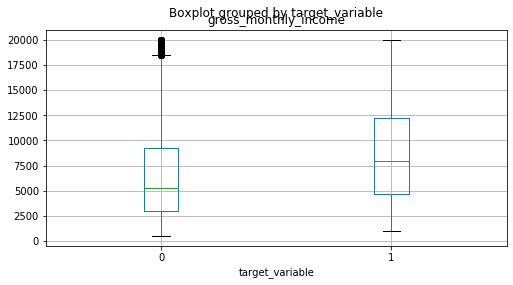

In [44]:
fig, ax = plt.subplots(figsize=(8, 4))
df_welcome.boxplot(column='gross_monthly_income', by= 'target_variable', ax=ax)

###### Here we notice that there is a clear distinction between the distribution of the gross monthly income for the 2 classes. <br>Gross Monthly income for positive result is on an  higher end. 


#### <span style="color:maroon"> Create job_duration bins
    
Based on the EDA before, we could sense that there are pre establisehd bins based on the frewuency, and hence 0-10,10-20,20-35 and 35 and above

In [45]:
#job_duration_bin
df_welcome.drop(df_welcome[df_welcome.job_duration>=80].index, inplace=True)
df_welcome['job_duration_bin']=df_welcome['job_duration'].copy()

df_welcome.loc[ (df_welcome.retired_check == 1) , 'job_duration_bin'] = "Retired_SS"
df_welcome['job_duration_bin']=df_welcome['job_duration_bin'].fillna('not_avl')
df_welcome.loc[(df_welcome.job_duration ==2 ) , 'job_duration_bin'] = "job_duration_1"
df_welcome.loc[(df_welcome.job_duration >=0 ) & (df_welcome.job_duration <10) , 'job_duration_bin'] = "job_duration_2"
df_welcome.loc[(df_welcome.job_duration >=10) & (df_welcome.job_duration <20) , 'job_duration_bin'] = "job_duration_3"

df_welcome.loc[(df_welcome.job_duration >=20 ) & (df_welcome.job_duration <35) , 'job_duration_bin'] = "job_duration_4"

df_welcome.loc[df_welcome.job_duration >=35 , 'job_duration_bin'] = "job_duration_5"

df_welcome.job_duration_bin.unique()

array(['job_duration_4', 'job_duration_2', 'job_duration_3',
       'job_duration_5'], dtype=object)

#### <span style="color:maroon">Delete columns not required for Analysis/Modeling

In [46]:
del df_welcome['retired_check']
del df_welcome['freq_payment']
del df_welcome['job_duration']
#del df_welcome['state']

#### <span style="color:maroon"> One-Hot encoding for categorical attributes

In [47]:
data=df_welcome.copy()

In [48]:
model_data1 = pd.get_dummies(data['type_of_income'])
model_data2 = pd.get_dummies(data['type_of_loan'])
model_data4 = pd.get_dummies(data['type_of_address'])
model_data5 = pd.get_dummies(data['day_of_week'])
model_data6 = pd.get_dummies(data['job_duration_bin'])
model_data7 = pd.get_dummies(data['state'])


In [49]:
new_data=pd.concat([data,model_data1],axis=1)
new_data=pd.concat([new_data,model_data2],axis=1)
new_data=pd.concat([new_data,model_data4],axis=1)
new_data=pd.concat([new_data,model_data5],axis=1)
new_data=pd.concat([new_data,model_data6],axis=1)
new_data=pd.concat([new_data,model_data7],axis=1)


In [50]:
new_data.head()


,user_id,date,validity_type_bad,bounce_type_soft,bounce_type_hard,bounce_type_other,paycheck_amount_gross,type_of_income,account_number,type_of_loan,...,job_duration_4,job_duration_5,AZ,CA,FL,GA,IL,IN,NJ,TX
0,30894,2019-12-31,0,0,0,0,2692,23,6887733,11,...,1,0,0,0,0,0,0,0,0,1
1,44938,2019-12-31,0,0,0,0,4999,15,7114767,7,...,0,0,0,1,0,0,0,0,0,0
2,23989,2019-12-31,0,0,0,0,1124,15,2940349,11,...,1,0,1,0,0,0,0,0,0,0
3,7661,2019-12-31,0,0,0,0,4754,7,7650219,30,...,1,0,0,0,0,0,0,0,1,0
4,78742,2019-12-31,0,1,0,0,2950,17,1876711,not_avl,...,0,0,0,0,0,0,0,0,0,1


#### <span style="color:maroon"> Delete the categorical columns once one hot encoding is done

In [51]:
data=new_data.copy()
del data['type_of_income']
del data['type_of_loan']
del data['state']
del data['type_of_address']
del data['day_of_week']
del data['job_duration_bin']
data['target']=data['target_variable']
del data['target_variable']

In [52]:
#set user_id as the first column
data=pd.concat([data['user_id'], data.drop(['user_id'], axis=1)], axis=1)

In [53]:
#set date as the first column
data=pd.concat([data['date'], data.drop(['date'], axis=1)], axis=1)

# 3. Session 3 -   Developing a Benchmark model-------------------------------------------

### <span style="color:blue"> 3.a) ML preparation 


#### <span style="color:maroon"> Split the dataset to training, validation, and testing

In [54]:
import random
random.seed(2019)
rand_split = np.random.rand(len(data))
train_list = rand_split <= 0.65
val_list = (rand_split > 0.65) & (rand_split < 0.8)
test_list = rand_split >= 0.8

train_data = data[train_list]
validation_data = data[val_list]
test_data = data[test_list]

#### <span style="color:maroon"> Amazon SageMaker's XGBoost container expects data in the libSVM or CSV data format.We are using CSV for this case

In [55]:
pd.concat([train_data['target'], train_data.drop(['target','user_id','date','account_number'], axis=1)], axis=1).to_csv('train.csv', index=False, header=False)
pd.concat([validation_data['target'], validation_data.drop(['target','user_id','date','account_number'], axis=1)], axis=1).to_csv('validation.csv', index=False, header=False)


#### <span style="color:maroon"> Now we'll copy the file to S3 for Amazon SageMaker's managed training to pickup.

In [56]:
sess.upload_data(path='train.csv', bucket=bucket, key_prefix=prefix+'/train/train.csv')
sess.upload_data(path='validation.csv', bucket=bucket, key_prefix=prefix+'/validation/validation.csv')

's3://aws-immersion-day--ml/PROPENSITY-DATA/01-EMAIL/xgboost/training-files/validation/validation.csv/validation.csv'

### <span style="color:blue">3.b) Training

#### <span style="color:maroon">  First we'll need to specify the ECR container location for Amazon SageMaker's implementation of XGBoost.

In [57]:
container = image_uris.retrieve('xgboost', boto3.Session().region_name, '1.2-1' )

#### <span style="color:maroon">  Then, because we're training with the CSV file format, we'll create s3_inputs that our training function can use as a pointer to the files in S3, which also specify that the content type is CSV.

In [58]:
s3_input_train = TrainingInput(s3_data='s3://{}/{}/train'.format(bucket, prefix), content_type='csv')
s3_input_validation = TrainingInput(s3_data='s3://{}/{}/validation/'.format(bucket, prefix), content_type='csv')

In [59]:
weight_scale = len(train_data[train_data['target']==0]['target'])/len(train_data[train_data['target']==1]['target'])
weight_scale

3.73313995649021

#### <span style="color:maroon">  First we'll need to specify training parameters to the estimator. This includes:

1) The xgboost algorithm container<br />
2) The IAM role to use<br />
3) Training instance type and count<br />
4) S3 location for output data<br />
5) Algorithm hyperparameters<br />
6) And then a .fit() function which specifies:<br />
S3 location for output data. In this case we have both a training and validation set which are passed in.

In [60]:
xgb = Estimator(container,
                role,
                instance_count=1,
                instance_type='ml.m5.large',
                output_path='s3://{}/{}/output'.format(bucket, prefix))

xgb.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        objective='binary:logistic',
                        num_round=100,
                       scale_pos_weight=weight_scale)

xgb.fit({'train': s3_input_train, 'validation': s3_input_validation}) 

2020-12-09 17:48:05 Starting - Starting the training job...
2020-12-09 17:48:07 Starting - Launching requested ML instances......
2020-12-09 17:49:13 Starting - Preparing the instances for training......
2020-12-09 17:50:13 Downloading - Downloading input data...
2020-12-09 17:51:06 Training - Training image download completed. Training in progress..INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter objective value binary:logistic to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Single node training.
INFO:root:Train matrix has 6527 rows
INFO:root

### <span style="color:blue">3.c) Hyper Parameter Training


# 4. Session 4 - Operationalization and Evaluation-----------------------------------------

### <span style="color:blue">Hosting- ENDPOINT CREATION


Now that we've trained the xgboost algorithm on our data, let's deploy a model that's hosted behind a real-time endpoint.

In [61]:
%%time
xgb_predictor = xgb.deploy(initial_instance_count=1,instance_type='ml.t2.medium')

---------------!CPU times: user 279 ms, sys: 12 ms, total: 291 ms
Wall time: 7min 32s


### <span style="color:blue">4.a) BATCH PREDICTIONS 
Function to get predictions from the endpoint hosted in the previous section(Hosting)

In [62]:

xgb_predictor.serializer = CSVSerializer()

def predict(data, rows=500):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        predictions = ','.join([predictions, xgb_predictor.predict(array).decode('utf-8')])
    return np.fromstring(predictions[1:], sep=',')

predictions = predict(test_data.drop(['target','user_id','date','account_number'], axis=1).to_numpy())

In [63]:
predictions=predictions.reshape((-1,))

### <span style="color:blue">4.b) REAL TIME PREDICTIONS : API Gateway and Lambda


<img src="https://d2908q01vomqb2.cloudfront.net/f1f836cb4ea6efb2a0b1b99f41ad8b103eff4b59/2018/07/18/sagemaker-endpoint-1.gif" alt="MarineGEO circle logo" style="height: 500; width:500;"/>

### <span style="color:blue">4.c) Evaluation

#### <span style="color:maroon">  Confusion matrix

In [64]:
cm=pd.crosstab(index=test_data['target'], columns=np.where(predictions>0.5,1,0), rownames=['actuals'], colnames=['predictions'])

cm

predictions,0,1
actuals,,
0,1487,7
1,1,441


#### <span style="color:maroon">Area Under the (Receiver Operating Characteristic) Curve (AUC)

In [65]:
test_y = test_data.iloc[:,data.columns.get_loc("target")].values;
import sklearn
from sklearn.metrics import roc_auc_score
predictions=predictions.astype(int)
test_y=test_y.astype(int)

sklearn.metrics.roc_auc_score(test_y, predictions)

0.5

#### <span style="color:maroon">  Delete Endpoint

In [66]:
xgb_predictor.delete_endpoint()